In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager
import scipy as sp
import scib
import seaborn as sns
import anndata as ad

In [2]:
class RootCellError(Exception):
    def __init__(self, message):
        self.message = message

In [3]:
plt.rcParams["font.size"] = 10
import warnings
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = (15, 15)
plt.rcParams.update({'axes.titlesize': 'x-large'})
sns.set(font_scale=1.5, style='white')
sns.set_context('poster')
sns.set(font_scale=1.5)
#sns.set_context("poster", rc={"axes.titlesize":20}) 
sns.set_style(style='white')
plt.rcParams["font.family"] = "sans-serif"
sns.set_palette(palette=sc.pl.palettes.godsnot_102)

In [4]:
def trajectory_conservation(
    adata_pre, adata_post, label_key, pseudotime_key="dpt_pseudotime", batch_key=None
):
    """Trajectory conservation score

    Trajectory conservation is measured by  spearman’s rank correlation coefficient :math:`s`, between the pseudotime
    values before and after integration.
    The final score was scaled to a value between 0 and 1 using the equation

     .. math::

        trajectory \\, conservation = \\frac {s + 1} {2}

    :param adata_pre: unintegrated adata
    :param adata_post: integrated adata
    :param label_key: column in ``adata_pre.obs`` of the groups used to precompute the trajectory
    :param pseudotime_key: column in ``adata_pre.obs`` in which the pseudotime is saved in.
        Column can contain empty entries, the dataset will be subset to the cells with scores.
    :param batch_key: set to batch key if you want to compute the trajectory metric by batch. By default the batch
        information will be ignored (``batch_key=None``)

    This function requires pseudotime values in ``.obs`` of the unintegrated object (``adata_pre``) computed per batch
    and can be applied to all integration output types.
    The input trajectories should be curated manually as the quality of the metric depends on the quality of the metric
    depends on the quality of the annotation.
    The integrated object (``adata_post``) needs to have a kNN graph based on the integration output.
    See :ref:`preprocessing` for more information on preprocessing.

    **Examples**

    .. code-block:: python

        # feature output
        scib.pp.reduce_data(
            adata, n_top_genes=2000, batch_key="batch", pca=True, neighbors=True
        )
        scib.me.trajectory_conservation(adata_unintegrated, adata, label_key="cell_type")

        # embedding output
        sc.pp.neighbors(adata, use_rep="X_emb")
        scib.me.trajectory_conservation(adata_unintegrated, adata, label_key="celltype")

        # knn output
        scib.me.trajectory_conservation(adata_unintegrated, adata, label_key="celltype")

    """
    # subset to cells for which pseudotime has been computed
    cell_subset = adata_pre.obs.index[adata_pre.obs[pseudotime_key].notnull()]
    adata_pre_ti = adata_pre[cell_subset]
    adata_post_ti = adata_post[cell_subset]
    try:
        iroot, adata_post_ti2 = get_root(
            adata_pre_ti, adata_post_ti, label_key, pseudotime_key
        )
    except RootCellError:
        print("No root cell found, setting trajectory conservation metric to 0.")
        return 0  # failure to find root cell means no TI conservation
    #print(iroot)
    adata_post_ti2.uns["iroot"] = iroot

    sc.tl.dpt(adata_post_ti2)  # stored in 'dpt_pseudotime'
    adata_post_ti2.obs.loc[
        adata_post_ti2.obs["dpt_pseudotime"] > 1, "dpt_pseudotime"
    ] = 0
    adata_post_ti.obs["dpt_pseudotime"] = 0
    adata_post_ti.obs["dpt_pseudotime"] = adata_post_ti2.obs["dpt_pseudotime"]
    adata_post_ti.obs["dpt_pseudotime"].fillna(0, inplace=True)

    if batch_key is None:
        pseudotime_before = adata_pre_ti.obs[pseudotime_key]
        pseudotime_after = adata_post_ti.obs["dpt_pseudotime"]
        correlation = pseudotime_before.corr(pseudotime_after, "spearman")
        return (correlation + 1) / 2  # scaled
    else:
        check_batch(batch_key, adata_pre.obs)
        check_batch(batch_key, adata_post.obs)

        # check if batches match
        if not np.array_equal(
            adata_post_ti.obs[batch_key], adata_pre_ti.obs[batch_key]
        ):
            raise ValueError(
                "Batch columns do not match\n"
                f"adata_post_ti.obs['batch']:\n {adata_post_ti.obs[batch_key]}\n"
                f"adata_pre_ti.obs['batch']:\n {adata_pre_ti.obs[batch_key]}\n"
            )

        corr = pd.Series()
        for i in adata_pre_ti.obs[batch_key].unique():
            pseudotime_before = adata_pre_ti.obs[adata_pre_ti.obs[batch_key] == i][
                pseudotime_key
            ]
            pseudotime_after = adata_post_ti.obs[adata_post_ti.obs[batch_key] == i][
                "dpt_pseudotime"
            ]
            corr[i] = pseudotime_before.corr(pseudotime_after, "spearman")

        return (corr.mean() + 1) / 2  # scaled


def get_root(adata_pre, adata_post, ct_key, pseudotime_key="dpt_pseudotime", dpt_dim=3):
    """Determine root cell for integrated adata based on unintegrated adata

    :param adata_pre: unintegrated adata
    :param adata_post: integrated adata
    :param label_key: column in ``adata_pre.obs`` of the groups used to precompute the trajectory
    :param pseudotime_key: column in ``adata_pre.obs`` in which the pseudotime is saved in.
        Column can contain empty entries, the dataset will be subset to the cells with scores.
    :param dpt_dim: number of diffmap dimensions used to determine root
    """
    n_components, adata_post.obs["neighborhood"] = connected_components(
        csgraph=adata_post.obsp["connectivities"], directed=False, return_labels=True
    )

    #start_clust = adata_pre.obs.groupby([ct_key],observed=True).mean()[pseudotime_key].idxmin()
    start_clust = adata_pre.obs.groupby([ct_key],observed=True)[pseudotime_key].mean().idxmin()
    #print(adata_post.obs["neighborhood"].value_counts().idxmax())
    min_dpt = adata_pre.obs[adata_pre.obs[ct_key] == start_clust].index
    # print('min_dpt',min_dpt)
    which_max_neigh = (
        adata_post.obs["neighborhood"]
        == adata_post.obs["neighborhood"].value_counts().idxmax()
    )
    # print('which_max_neigh',which_max_neigh)
    # print('adata_post.obs[which_max_neigh].index',adata_post.obs[which_max_neigh].index)
    min_dpt = [
        value for value in min_dpt if value in adata_post.obs[which_max_neigh].index
    ]
    # print('min_dpt',min_dpt)
    adata_post_ti = adata_post[which_max_neigh]

    min_dpt = [adata_post_ti.obs_names.get_loc(i) for i in min_dpt]
    
    # compute Diffmap for adata_post
    sc.tl.diffmap(adata_post_ti)
    # print('adata_post_ti.obs',adata_post_ti.obs)
    # print('min_dpt',min_dpt)
    # determine most extreme cell in adata_post Diffmap
    min_dpt_cell = np.zeros(len(min_dpt))
    for dim in np.arange(dpt_dim):

        diffmap_mean = adata_post_ti.obsm["X_diffmap"][:, dim].mean()
        diffmap_min_dpt = adata_post_ti.obsm["X_diffmap"][min_dpt, dim]
        # count opt cell
        if len(diffmap_min_dpt) == 0:
            raise RootCellError("No root cell in largest component")
            #continue

        # choose optimum function
        if len(diffmap_min_dpt) > 0 and diffmap_min_dpt.mean() < diffmap_mean:
            opt = np.argmin
        else:
            opt = np.argmax

        min_dpt_cell[opt(diffmap_min_dpt)] += 1

    # root cell is cell with max vote
    return min_dpt[np.argmax(min_dpt_cell)], adata_post_ti

In [5]:
from scipy.sparse.csgraph import connected_components

def run_pp(adata, adata_int, type_, changeCT = False):
    # DATA REDUCTION
    # select options according to type
    
    if changeCT:
        adata.obs.loc[adata.obs.final_annotation == 'Lymphocyte progenitors', 'final_annotation'] = 'HSPCs'
        adata_int.obs.loc[adata_int.obs.final_annotation == 'Lymphocyte progenitors', 'final_annotation'] = 'HSPCs'
        
    if len(set(adata.obs_names).difference(set(adata_int.obs_names))) > 0:
        #rename adata_int.obs[batch_key] labels by overwriting them with the pre-integration labels
        #new_obs_names = ['-'.join(idx.split('-')[:-1]) for idx in adata_int.obs_names]

        if len(set(adata.obs_names).difference(set(new_obs_names))) == 0:
            adata_int.obs_names = new_obs_names
        else:
            print(set(adata.obs_names).difference(set(new_obs_names)))
            raise ValueError('obs_names changed after integration!')
    
    if adata.n_vars > adata_int.n_vars:
        n_hvgs = None
    
    # case 1: full expression matrix, default settings
    precompute_pca = True
    recompute_neighbors = True
    embed = 'X_pca'
    n_hvgs=2000
    #n_hvgs=15
    
    # distinguish between subsetted and full expression matrix
    # compute HVGs only if output is not already subsetted
    if adata.n_vars > adata_int.n_vars:
        n_hvgs = None
    
    # case 2: embedding output
    if (type_ == "embed"):
        n_hvgs = 10    #change to 15
        embed = "X_emb"
        # legacy check
        if ('emb' in adata_int.uns) and (adata_int.uns['emb']):
            adata_int.obsm["X_emb"] = adata_int.obsm["X_pca"].copy()
    
    # case3: kNN graph output
    elif (type_ == "graph"):
        n_hvgs = None
        precompute_pca = False
        recompute_neighbors = False
    
    sc.pp.filter_genes(adata_int, min_cells=1)
    scib.preprocessing.reduce_data(adata_int,
                                   n_top_genes=n_hvgs,
                                   neighbors=recompute_neighbors, use_rep=embed,
                                   pca=precompute_pca, umap=False)

def trajectory_plot(adata_pre, adata_post, label_key, type_, changeCT=False):
    #if len(set(adata_pre.obs_names).difference(set(adata_post.obs_names))) > 0:
        #rename adata_int.obs[batch_key] labels by overwriting them with the pre-integration labels
        #new_obs_names = ['-'.join(idx.split('-')[:-1]) for idx in adata_post.obs_names]
        #new_obs_names = adata_post.obs_names.str[-2]

        #if len(set(adata_pre.obs_names).difference(set(new_obs_names))) == 0:
            #adata_post.obs_names = new_obs_names
        #else:
        #    #print((set(adata_pre.obs_names).difference(set(new_obs_names))))
        #    print(new_obs_names[:10])
        #    raise ValueError('obs_names changed after integration!')
    adata_post.obs_names = adata_pre.obs_names
    #run_pp(adata_pre, adata_post, type_, changeCT=changeCT)
    
    cell_subset = adata_pre.obs.index[adata_pre.obs["dpt_pseudotime"].notnull()]
    # print(len(cell_subset))
    # print(adata_pre)
    adata_pre_sub = adata_pre[cell_subset]
    adata_post_sub = adata_post[cell_subset]
    
    iroot, adata_post_sub2 = get_root(adata_pre_sub, adata_post_sub, label_key)
    adata_post_sub2.uns["iroot"] = iroot
    if adata_post_sub2:
        sc.tl.dpt(adata_post_sub2)
        #adata_post_sub.obs['dpt_pseudotime'][adata_post_sub.obs['dpt_pseudotime']>1]=0
        #return (adata_post_sub.obs['dpt_pseudotime'].corr(adata_pre_sub.obs['dpt_pseudotime'], 'spearman')+1)/2
        #adata_pre_sub.obs['dpt_after'] = adata_post_sub.obs['dpt_pseudotime']
    
        adata_post_sub.obs['dpt_after'] = pd.Series(range(len(adata_post_sub2.obs)), index=adata_post_sub2.obs.sort_values('dpt_pseudotime').index)
    else:
        adata_post_sub.obs['dpt_after'] = 0
        #adata_post_wo = adata_post_sub[adata_post_sub.obs.dpt_pseudotime!=0]
    """if 'conos' in label:
            sc.tl.draw_graph(adata_post_sub)
            sc.pl.umap(adata_post_sub, color='dpt_after', title=label, show=False, frameon=False, ax=ax)
        else:    
            #sc.tl.umap(adata_post_sub)
            #sc.pl.umap(adata_post_sub, color='dpt_after', title=label, show=False, frameon=False, ax=ax)

    else:
        #adata_pre_draw.obs['dpt_after'] = pd.Series(range(len(adata_pre_draw.obs)), index=adata_post_sub.obs.sort_values('dpt_pseudotime').index)
        #sc.tl.umap(adata_pre_draw)
        #sc.pl.umap(adata_pre_draw, color='dpt_after', title=label, show=False, frameon=False, ax=ax)"""
    return adata_pre_sub, adata_post_sub

In [112]:
bindsc_emb=sc.read_h5ad('../../results/bindSC-output/10x-Multiome-Pbmc10k-small/10x-Multiome-Pbmc10k-small-rna_fake.h5ad')
Deepmaps_emb=sc.read_h5ad('../../results/Deepmaps-output/10x-Multiome-Pbmc10k-small/10x-Multiome-Pbmc10k-small-rna_fake.h5ad')
GLUE_emb=sc.read_h5ad('../../results//GLUE-output/10x-Multiome-Pbmc10k-small/10x-Multiome-Pbmc10k-small-rna_fake.h5ad')
iNMF_emb=sc.read_h5ad('../../results/scripts/iNMF-output/10x-Multiome-Pbmc10k-small/10x-Multiome-Pbmc10k-small-rna_fake.h5ad')
LIGER_emb=sc.read_h5ad('../../results/LIGER-output/10x-Multiome-Pbmc10k-small/10x-Multiome-Pbmc10k-small-rna_fake.h5ad')
MOFA_emb=sc.read_h5ad('../../results/MOFA-output/10x-Multiome-Pbmc10k-small/10x-Multiome-Pbmc10k-small-rna_fake.h5ad')
Pamona_emb=sc.read_h5ad('../../results/Pamona-output/10x-Multiome-Pbmc10k-small/10x-Multiome-Pbmc10k-small-rna_fake.h5ad')
PCA_emb=sc.read_h5ad('../../results/PCA-output/10x-Multiome-Pbmc10k-small/10x-Multiome-Pbmc10k-small-rna_fake.h5ad')
scJoint_emb=sc.read_h5ad('../../results/scJoint-output/10x-Multiome-Pbmc10k-small/10x-Multiome-Pbmc10k-small-rna_fake.h5ad')
scMDC_emb=sc.read_h5ad('../../results/scMDC-output/10x-Multiome-Pbmc10k-small/10x-Multiome-Pbmc10k-small-rna_fake.h5ad')
scMoMaT_emb=sc.read_h5ad('../../results/scMoMaT-output/10x-Multiome-Pbmc10k-small/10x-Multiome-Pbmc10k-small-rna_fake.h5ad')
scVI_emb=sc.read_h5ad('../../results/scVI-output/10x-Multiome-Pbmc10k-small/10x-Multiome-Pbmc10k-small-rna_fake.h5ad')
seurat4_emb=sc.read_h5ad('../../results/seurat4-output/10x-Multiome-Pbmc10k-small/10x-Multiome-Pbmc10k-small-rna_fake.h5ad')
seurat5_emb=sc.read_h5ad('../../results/seurat5-output/10x-Multiome-Pbmc10k-small/10x-Multiome-Pbmc10k-small-rna_fake.h5ad')
TotalVI_emb=sc.read_h5ad('../../results/scripts/TotalVI-output/10x-Multiome-Pbmc10k-small/10x-Multiome-Pbmc10k-small-rna_fake.h5ad')
Cobolt_emb=sc.read_h5ad('../../results/scripts/Cobolt-output/10x-Multiome-Pbmc10k-small/10x-Multiome-Pbmc10k-small-rna_fake.h5ad')
MMD_MA_emb=sc.read_h5ad('../../results/MMD_MA-output/10x-Multiome-Pbmc10k-small/10x-Multiome-Pbmc10k-small-rna_fake.h5ad')
UnionCom_emb=sc.read_h5ad('../../results/UnionCom-output/10x-Multiome-Pbmc10k-small/10x-Multiome-Pbmc10k-small-rna_fake.h5ad')
Geneformer_emb=sc.read_h5ad('../../results/Geneformer-output/10x-Multiome-Pbmc10k-small/10x-Multiome-Pbmc10k-small-rna_fake.h5ad')
scFoundation_emb=sc.read_h5ad('../../results/scFoundation-output/10x-Multiome-Pbmc10k-small/10x-Multiome-Pbmc10k-small-rna_fake.h5ad')
scGPT_emb=sc.read_h5ad('../../results/scGPT-output/10x-Multiome-Pbmc10k-small/10x-Multiome-Pbmc10k-small-rna_fake.h5ad')
scGPT_zero_emb=sc.read_h5ad('../../results/scGPT-zero-output/10x-Multiome-Pbmc10k-small/10x-Multiome-Pbmc10k-small-rna_fake.h5ad')
UCE_emd=sc.read_h5ad('../../results/UCE-output/10x-Multiome-Pbmc10k-small/10x-Multiome-Pbmc10k-small-rna_fake.h5ad')

In [113]:
emb=[Deepmaps_emb
,TotalVI_emb
,UnionCom_emb
,Pamona_emb
,GLUE_emb
,bindsc_emb
,Geneformer_emb
,scJoint_emb
,scVI_emb
,UCE_emd
,scFoundation_emb
,seurat4_emb
,MMD_MA_emb
,scGPT_emb
,PCA_emb
,scMoMaT_emb
,iNMF_emb
,LIGER_emb
,MOFA_emb
,Cobolt_emb
,scGPT_zero_emb
,seurat5_emb
,scMDC_emb]

titles=['Deepmaps'
,'TotalVI'
,'UnionCom'
,'Pamona'
,'GLUE'
,'bindSC'
,'Geneformer'
,'scJoint'
,'scVI'
,'UCE'
,'scFoundation'
,'Seurat4'
,'MMD_MA'
,'scGPT'
,'PCA'
,'scMoMaT'
,'iNMF'
,'LIGER'
,'MOFA'
,'Cobolt'
,'scGPT_zero'
,'Seurat5'
,'scMDC']

scores=[0.7415
,0.7066
,0.7047
,0.7014
,0.6920
,0.6869
,0.6654
,0.6648
,0.6575
,0.6548
,0.6501
,0.6318
,0.6138
,0.5800
,0.5390
,0.5145
,0.5015
,0.4593
,0.4536
,0.4196
,0.4104
,0.3937
,0.3569]
#tmp_emb=[scJoint_emb]
#tmp_titles=['scJoint']

In [114]:
rna=ad.read_h5ad('../../data/download/10x-Multiome-Pbmc10k/10x-Multiome-Pbmc10k-small-RNA.h5ad')
atac=ad.read_h5ad('../../data/download/10x-Multiome-Pbmc10k/10x-Multiome-Pbmc10k-small-ACTIVE.h5ad')

In [115]:
rna

AnnData object with n_obs × n_vars = 9631 × 8000
    obs: 'domain', 'protocol', 'dataset', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'ATAC.weight', 'wsnn_res.0.8', 'seurat_clusters', 'sub.cluster', 'cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_type', 'gene_name', 'hgnc_id', 'havana_gene', 'tag', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg'

In [116]:
atac

AnnData object with n_obs × n_vars = 9631 × 28307
    obs: 'domain', 'protocol', 'dataset', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'ATAC.weight', 'wsnn_res.0.8', 'seurat_clusters', 'sub.cluster', 'cell_type'
    var: 'colnames.activity.'

In [117]:
# 获取索引交集
intersection = atac.var.index.intersection(rna.var.index)

# 打印结果
print(len(intersection),intersection)

5909 Index(['A2M', 'A2M-AS1', 'A2ML1', 'A4GNT', 'AADACL2-AS1', 'AAGAB', 'AASS',
       'AATBC', 'ABAT', 'ABCA1',
       ...
       'ZNRF3', 'ZPLD1', 'ZRANB2-AS2', 'ZRANB3', 'ZSCAN1', 'ZSCAN31',
       'ZSCAN5A', 'ZSWIM3', 'ZSWIM5', 'ZSWIM6'],
      dtype='object', length=5909)


In [118]:
rna

AnnData object with n_obs × n_vars = 9631 × 8000
    obs: 'domain', 'protocol', 'dataset', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'ATAC.weight', 'wsnn_res.0.8', 'seurat_clusters', 'sub.cluster', 'cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_type', 'gene_name', 'hgnc_id', 'havana_gene', 'tag', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg'

In [119]:
# branch_1=['HSPC','CD8 TEM_2','CD8 TEM_1','CD4 Naive','CD8 Naive','CD4 TCM','CD4 TEM','Naive B','Memory B','Intermediate B','NK','CD16 Mono','CD14 Mono']
branch_1=['HSPC','CD8 TEM_2','CD8 TEM_1','CD4 Naive','CD8 Naive','CD4 TCM','CD4 TEM','Naive B','Memory B','Intermediate B']
rna=rna[rna.obs['cell_type'].isin(branch_1)]
atac=atac[atac.obs['cell_type'].isin(branch_1)]
emb_branch_1=[]
count=0
for e in emb:
    t=e[e.obs['cell_type'].isin(branch_1)]
    print(t)
    count+=1
    emb_branch_1.append(t)
print(count)
emb=emb_branch_1

View of AnnData object with n_obs × n_vars = 11024 × 128
    obs: 'domain', 'protocol', 'dataset', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'ATAC.weight', 'wsnn_res.0.8', 'seurat_clusters', 'sub.cluster', 'cell_type'
    uns: 'neighbors', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'
View of AnnData object with n_obs × n_vars = 11024 × 20
    obs: 'domain', 'protocol', 'dataset', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'ATAC.weight', 'wsnn_res.0.8', 'seurat_clusters', 'sub.cluster', 'cell_type'
    uns: 'neighbors', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'
View of AnnData object with n_obs × n_vars = 11024 × 32
    obs: 'domain', 'protocol', 'dataset', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_ATAC', 'nFeat

In [120]:
rna_intersection = rna[:,intersection]
rna_intersection
atac_intersection = atac[:,intersection]
atac_intersection

View of AnnData object with n_obs × n_vars = 5512 × 5909
    obs: 'domain', 'protocol', 'dataset', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'ATAC.weight', 'wsnn_res.0.8', 'seurat_clusters', 'sub.cluster', 'cell_type'
    var: 'colnames.activity.'

In [121]:
atac_intersection.X.toarray()

array([[0.          , 0.          , 0.          , ..., 0.          ,
        0.          , 0.          ],
       [0.          , 0.          , 0.          , ..., 0.          ,
        0.          , 0.          ],
       [0.          , 0.          , 0.          , ..., 0.          ,
        0.          , 0.          ],
       ...,
       [0.0036823691, 0.12675811  , 0.          , ..., 0.          ,
        0.          , 0.          ],
       [0.          , 0.          , 0.          , ..., 0.0035067492,
        0.34083164  , 0.042125862 ],
       [0.          , 0.          , 0.          , ..., 0.          ,
        0.          , 0.          ]], dtype=float32)

In [122]:
rna_intersection.X.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [2., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [123]:
rna_intersection.obs

domain      protocol                   dataset  \
cells                                                                   
AAACAGCCAATCCCTT-1  scRNA-seq  10x Multiome  10x-Multiome-Pbmc10k-RNA   
AAACAGCCAATGCGCT-1  scRNA-seq  10x Multiome  10x-Multiome-Pbmc10k-RNA   
AAACAGCCACCAACCG-1  scRNA-seq  10x Multiome  10x-Multiome-Pbmc10k-RNA   
AAACAGCCAGGATAAC-1  scRNA-seq  10x Multiome  10x-Multiome-Pbmc10k-RNA   
AAACAGCCAGTTTACG-1  scRNA-seq  10x Multiome  10x-Multiome-Pbmc10k-RNA   
...                       ...           ...                       ...   
TTTGTGTTCGGGACCT-1  scRNA-seq  10x Multiome  10x-Multiome-Pbmc10k-RNA   
TTTGTTGGTGACATGC-1  scRNA-seq  10x Multiome  10x-Multiome-Pbmc10k-RNA   
TTTGTTGGTGTTAAAC-1  scRNA-seq  10x Multiome  10x-Multiome-Pbmc10k-RNA   
TTTGTTGGTTGGTTAG-1  scRNA-seq  10x Multiome  10x-Multiome-Pbmc10k-RNA   
TTTGTTGGTTTGCAGA-1  scRNA-seq  10x Multiome  10x-Multiome-Pbmc10k-RNA   

                       orig.ident  nCount_RNA  nFeature_RNA  percent.mt  \
cells                                                                     
AAACAGCCAATCCCTT-1  SeuratProject      3771.0        1896.0   10.527711   
AAACAGCCAATGCGCT-1  SeuratProject      6876.0        2904.0    6.457243   
AAACAGCCACCAACCG-1  SeuratProject      5415.0        2282.0    6.500462   
AAACAGCCAGGATAAC-1  SeuratProject      2759.0        1353.0    6.922798   
AAACAGCCAGTTTACG-1  SeuratProject      3633.0        1691.0    4.183870   
...                           ...         ...           ...         ...   
TTTGTGTTCGGGACCT-1  SeuratProject      3184.0        1590.0   13.913317   
TTTGTTGGTGACATGC-1  SeuratProject      3285.0        1586.0   10.898021   
TTTGTTGGTGTTAAAC-1  SeuratProject      2866.0        1525.0   11.060712   
TTTGTTGGTTGGTTAG-1  SeuratProject      2976.0        1620.0    5.342742   
TTTGTTGGTTTGCAGA-1  SeuratProject      4505.0        1920.0    7.458380   

                    nCount_ATAC  nFeature_ATAC  nCount_SCT  nFeature_SCT  \
cells                                                                      
AAACAGCCAATCCCTT-1      20485.0         7247.0      3781.0        1895.0   
AAACAGCCAATGCGCT-1      16674.0         6528.0      4686.0        2769.0   
AAACAGCCACCAACCG-1       7658.0         3323.0      4486.0        2278.0   
AAACAGCCAGGATAAC-1      10355.0         4267.0      3332.0        1352.0   
AAACAGCCAGTTTACG-1      20516.0         7241.0      3676.0        1691.0   
...                         ...            ...         ...           ...   
TTTGTGTTCGGGACCT-1      23621.0         8264.0      3467.0        1590.0   
TTTGTTGGTGACATGC-1      15264.0         5715.0      3489.0        1585.0   
TTTGTTGGTGTTAAAC-1      17865.0         6628.0      3310.0        1524.0   
TTTGTTGGTTGGTTAG-1      17053.0         6366.0      3341.0        1618.0   
TTTGTTGGTTTGCAGA-1      22722.0         7572.0      4232.0        1920.0   

                    SCT.weight  ATAC.weight  wsnn_res.0.8  seurat_clusters  \
cells                                                                        
AAACAGCCAATCCCTT-1    0.507959     0.492041           4.0              4.0   
AAACAGCCAATGCGCT-1    0.425481     0.574519           1.0              1.0   
AAACAGCCACCAACCG-1    0.471465     0.528535           2.0              2.0   
AAACAGCCAGGATAAC-1    0.538544     0.461456           1.0              1.0   
AAACAGCCAGTTTACG-1    0.461856     0.538144           4.0              4.0   
...                        ...          ...           ...              ...   
TTTGTGTTCGGGACCT-1    0.454430     0.545570           2.0              2.0   
TTTGTTGGTGACATGC-1    0.399426     0.600574           2.0              2.0   
TTTGTTGGTGTTAAAC-1    0.795064     0.204936           8.0              8.0   
TTTGTTGGTTGGTTAG-1    0.598785     0.401215           3.0              3.0   
TTTGTTGGTTTGCAGA-1    0.521182     0.478818          12.0             12.0   

                   sub.cluster  cell_type  
cells                                      
AAACA

In [124]:
id=4
# sc.pp.pca(multiome_rna)
# sc.pp.neighbors(multiome_rna)
# #sc.tl.draw_graph(rna)
# # sc.pp.neighbors(multiome_rna)
# indices = np.where(np.array(multiome_rna.obs['cell_type'] == 'HSPC'))[0]
#     #rna.uns["iroot"] = np.random.choice(indices)
# multiome_rna.uns["iroot"] = indices[1]

# sc.tl.diffmap(multiome_rna)
# #sc.pp.neighbors(rna,use_rep='X_diffmap')
# sc.tl.dpt(multiome_rna)
indices = np.where(np.array(rna_intersection.obs['cell_type'] == 'HSPC'))[0]
rna_intersection.uns["iroot"] = indices[id]
sc.pp.pca(rna_intersection)
sc.pp.neighbors(rna_intersection)
sc.tl.diffmap(rna_intersection)
sc.tl.dpt(rna_intersection)
# print(rna_intersection.uns['diffmap_evals'].shape)
indices = np.where(np.array(atac_intersection.obs['cell_type'] == 'HSPC'))[0]
atac_intersection.uns["iroot"] = indices[id]
sc.pp.pca(atac_intersection)
sc.pp.neighbors(atac_intersection)
sc.tl.diffmap(atac_intersection)
sc.tl.dpt(atac_intersection)
print(atac_intersection.uns['diffmap_evals'].shape)
obs_index=list(rna.obs.index)
fake_atac_index=[x + '_atac' for x in obs_index]
fake_atac=atac_intersection.copy()
fake_atac.obs['index']=fake_atac_index
fake_atac.obs.set_index('index',inplace=True)
# print('rna',rna.obs)
# multiome_rna = ad.concat([rna, fake_atac])
multiome_rna = ad.concat([rna_intersection, fake_atac])
multiome_rna.uns["iroot"] = indices[id]
print(indices)

(15,)
[ 294 1575 2395 2435 3082 3634 3808 4253 4463 4490 4531 4669 4740 5113
 5214 5397 5408]


In [125]:
temp_rna_diff=rna_intersection.uns['diffmap_evals']
temp_atac_diff=atac_intersection.uns['diffmap_evals']
temp_diff=(temp_atac_diff+temp_rna_diff)/2
multiome_rna.uns['diffmap_evals']=temp_diff
temp_dic=rna_intersection.uns['neighbors']
multiome_rna.uns['neighbors']=temp_dic

In [126]:
# sc.pp.pca(multiome_rna)
# removed_data = multiome_rna.obsm.pop('X_diffmap')
sc.pp.neighbors(multiome_rna)
sc.tl.diffmap(multiome_rna)
sc.tl.dpt(multiome_rna)
multiome_rna.obs

domain      protocol                    dataset  \
AAACAGCCAATCCCTT-1        scRNA-seq  10x Multiome   10x-Multiome-Pbmc10k-RNA   
AAACAGCCAATGCGCT-1        scRNA-seq  10x Multiome   10x-Multiome-Pbmc10k-RNA   
AAACAGCCACCAACCG-1        scRNA-seq  10x Multiome   10x-Multiome-Pbmc10k-RNA   
AAACAGCCAGGATAAC-1        scRNA-seq  10x Multiome   10x-Multiome-Pbmc10k-RNA   
AAACAGCCAGTTTACG-1        scRNA-seq  10x Multiome   10x-Multiome-Pbmc10k-RNA   
...                             ...           ...                        ...   
TTTGTGTTCGGGACCT-1_atac  scATAC-seq  10x Multiome  10x-Multiome-Pbmc10k-ATAC   
TTTGTTGGTGACATGC-1_atac  scATAC-seq  10x Multiome  10x-Multiome-Pbmc10k-ATAC   
TTTGTTGGTGTTAAAC-1_atac  scATAC-seq  10x Multiome  10x-Multiome-Pbmc10k-ATAC   
TTTGTTGGTTGGTTAG-1_atac  scATAC-seq  10x Multiome  10x-Multiome-Pbmc10k-ATAC   
TTTGTTGGTTTGCAGA-1_atac  scATAC-seq  10x Multiome  10x-Multiome-Pbmc10k-ATAC   

                            orig.ident  nCount_RNA  nFeature_RNA  percent.mt  \
AAACAGCCAATCCCTT-1       SeuratProject      3771.0        1896.0   10.527711   
AAACAGCCAATGCGCT-1       SeuratProject      6876.0        2904.0    6.457243   
AAACAGCCACCAACCG-1       SeuratProject      5415.0        2282.0    6.500462   
AAACAGCCAGGATAAC-1       SeuratProject      2759.0        1353.0    6.922798   
AAACAGCCAGTTTACG-1       SeuratProject      3633.0        1691.0    4.183870   
...                                ...         ...           ...         ...   
TTTGTGTTCGGGACCT-1_atac  SeuratProject      3184.0        1590.0   13.913317   
TTTGTTGGTGACATGC-1_atac  SeuratProject      3285.0        1586.0   10.898021   
TTTGTTGGTGTTAAAC-1_atac  SeuratProject      2866.0        1525.0   11.060712   
TTTGTTGGTTGGTTAG-1_atac  SeuratProject      2976.0        1620.0    5.342742   
TTTGTTGGTTTGCAGA-1_atac  SeuratProject      4505.0        1920.0    7.458380   

                         nCount_ATAC  nFeature_ATAC  nCount_SCT  nFeature_SCT  \
AAACAGCCAATCCCTT-1           20485.0         7247.0      3781.0        1895.0   
AAACAGCCAATGCGCT-1           16674.0         6528.0      4686.0        2769.0   
AAACAGCCACCAACCG-1            7658.0         3323.0      4486.0        2278.0   
AAACAGCCAGGATAAC-1           10355.0         4267.0      3332.0        1352.0   
AAACAGCCAGTTTACG-1           20516.0         7241.0      3676.0        1691.0   
...                              ...            ...         ...           ...   
TTTGTGTTCGGGACCT-1_atac      23621.0         8264.0      3467.0        1590.0   
TTTGTTGGTGACATGC-1_atac      15264.0         5715.0      3489.0        1585.0   
TTTGTTGGTGTTAAAC-1_atac      17865.0         6628.0      3310.0        1524.0   
TTTGTTGGTTGGTTAG-1_atac      17053.0         6366.0      3341.0        1618.0   
TTTGTTGGTTTGCAGA-1_atac      22722.0         7572.0      4232.0        1920.0   

                         SCT.weight  ATAC.weight  wsnn_res.0.8  \
AAACAGCCAATCCCTT-1         0.507959     0.492041           4.0   
AAACAGCCAATGCGCT-1         0.425481     0.574519           1.0   
AAACAGCCACCAACCG-1         0.471465     0.528535           2.0   
AAACAGCCAGGATAAC-1         0.538544     0.461456           1.0   
AAACAGCCAGTTTACG-1         0.461856     0.538144           4.0   
...                             ...          ...           ...   
TTTGTGTTCGGGACCT-1_atac    0.454430     0.545570           2.0   
TTTGTTGGTGACATGC-1_atac    0.399426     0.600574           2.0   
TTTGTTGGTGTTAAAC-1_atac    0.795064     0.204936           8.0   
TTTGTTGGTTGGTTAG-1_atac    0.598785     0.401215           3.0   
TTTGTTGGTTTGCAGA-1_atac    0.521182     0.478818          12.0   

                         seurat_clusters sub.cluster  cell_type  \
AAACAGCCAATCCCTT-1                   4.0           4    CD4 TCM   
AAACAGCCAATGCGCT-1                   1.0           1  CD4 Naive   
AAACAGCCACCAACCG-1                   2.0           2  CD8 Naive   
AAACAGCCAGGATAAC-1                   1.0           1  CD4 Naive   
AAACAG

In [127]:
# multiome_rna.obs.groupby(['cell_type'],observed=True)['dpt_pseudotime'].mean().idxmin()
temp_dpt_pseudotime=multiome_rna.obs.groupby(['cell_type'],observed=True)['dpt_pseudotime'].mean()

In [128]:
pd.DataFrame(rna_intersection.obs.groupby(['cell_type'],observed=True)['dpt_pseudotime'].mean())

dpt_pseudotime
cell_type                     
CD4 TCM               0.076622
CD4 Naive             0.072956
CD8 Naive             0.075918
CD4 TEM               0.085342
Naive B               0.841836
CD8 TEM_1             0.086345
Memory B              0.845585
CD8 TEM_2             0.133048
Intermediate B        0.848274
HSPC                  0.220099

In [129]:
pd.DataFrame(temp_dpt_pseudotime)

dpt_pseudotime
cell_type                     
CD4 TCM               0.063798
CD4 Naive             0.062365
CD8 Naive             0.061907
CD4 TEM               0.069884
Naive B               0.807971
CD8 TEM_1             0.065854
Memory B              0.811886
CD8 TEM_2             0.102748
Intermediate B        0.817888
HSPC                  0.224333

In [131]:
multiome_rna.uns["neighbors"]

{'connectivities_key': 'connectivities',
 'distances_key': 'distances',
 'params': {'n_neighbors': 15,
  'method': 'umap',
  'random_state': 0,
  'metric': 'euclidean'}}

In [132]:
len(list(set(list(multiome_rna.obs.index))))

11024

In [133]:
# score = trajectory_conservation(
#         adata_pre=multiome_rna,
#         adata_post=scMDC_emb,
#         label_key="cell_type",
#         pseudotime_key="dpt_pseudotime",
#     )

# print(score)

In [134]:
all_dpt=[]
for idx,i in enumerate(emb):
    print(idx)
    sc.pp.pca(i)
#sc.tl.draw_graph(emb_rna)
    sc.pp.neighbors(i)
    adata_pre_sub, adata_post_sub=trajectory_plot(multiome_rna,i,"cell_type","embed")
    all_dpt.append(adata_post_sub)

    score = trajectory_conservation(
            adata_pre=adata_pre_sub,
            adata_post=adata_post_sub,
            label_key="cell_type",
            pseudotime_key="dpt_pseudotime",
        )

    print(score)
        
    

0


0.7296753346468874
1
0.6826759940336664
2
0.6664362475978249
3
0.7071837124877921
4
0.6946602489124736
5
0.6892191215787445
6
0.6642072297327299
7
0.6272102923957247
8
0.5276787851483942
9
0.6392665638044435
10
0.6357714589063175
11
0.6292710234893149
12
0.6266814680286569
13
0.5611543609942282
14
0.7693774907854045
15
0.5030440215323368
16
0.48937313964035695
17
0.5485149633034636
18
0.47168776169086246
19
0.4349037410816682
20
0.4398750775110787
21
0.4041770349100042
22
0.37867917506693766


In [135]:
adata_post_sub

AnnData object with n_obs × n_vars = 11024 × 16
    obs: 'domain', 'protocol', 'dataset', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'ATAC.weight', 'wsnn_res.0.8', 'seurat_clusters', 'sub.cluster', 'cell_type', 'neighborhood', 'dpt_after'
    uns: 'neighbors', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [136]:
all_dpt[0]

AnnData object with n_obs × n_vars = 11024 × 128
    obs: 'domain', 'protocol', 'dataset', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'ATAC.weight', 'wsnn_res.0.8', 'seurat_clusters', 'sub.cluster', 'cell_type', 'neighborhood', 'dpt_after'
    uns: 'neighbors', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [137]:
adata_pre_sub

View of AnnData object with n_obs × n_vars = 11024 × 5909
    obs: 'domain', 'protocol', 'dataset', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'ATAC.weight', 'wsnn_res.0.8', 'seurat_clusters', 'sub.cluster', 'cell_type', 'dpt_pseudotime'
    uns: 'iroot', 'diffmap_evals', 'neighbors'
    obsm: 'X_pca', 'X_diffmap'
    obsp: 'distances', 'connectivities'

In [138]:
sc.tl.umap(adata_pre_sub,random_state=0)
adata_pre_sub

AnnData object with n_obs × n_vars = 11024 × 5909
    obs: 'domain', 'protocol', 'dataset', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'ATAC.weight', 'wsnn_res.0.8', 'seurat_clusters', 'sub.cluster', 'cell_type', 'dpt_pseudotime'
    uns: 'iroot', 'diffmap_evals', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_diffmap', 'X_umap'
    obsp: 'distances', 'connectivities'

In [139]:
sc.tl.paga(adata_pre_sub, groups="cell_type")

In [140]:
adata_pre_sub.uns

OrderedDict([('iroot', 3082),
             ('diffmap_evals',
              array([1.        , 0.99718565, 0.9834625 , 0.97660315, 0.9710413 ,
                     0.96408033, 0.955916  , 0.94716114, 0.93920296, 0.93717104,
                     0.93035626, 0.9245456 , 0.92027515, 0.9120744 , 0.89884   ],
                    dtype=float32)),
             ('neighbors',
              {'connectivities_key': 'connectivities',
               'distances_key': 'distances',
               'params': {'n_neighbors': 15,
                'method': 'umap',
                'random_state': 0,
                'metric': 'euclidean'}}),
             ('umap',
              {'params': {'a': 0.583030020479462, 'b': 1.3341669929263487}}),
             ('paga',
              {'connectivities': <10x10 sparse matrix of type '<class 'numpy.float64'>'
               	with 86 stored elements in Compressed Sparse Row format>,
               'connectivities_tree': <10x10 sparse matrix of type '<class 'numpy.float64'>

In [141]:
# sc.tl.louvain(adata_pre_sub, resolution=1.0)
# sc.tl.paga(adata_pre_sub, groups="louvain")
# sc.pl.paga(adata_pre_sub)

In [142]:
# adata_pre_sub.obs["louvain_anno"] = adata_pre_sub.obs["louvain"]
# sc.tl.paga(adata_pre_sub, groups="louvain_anno")
# sc.pl.paga(adata_pre_sub, threshold=0.03, show=False)


In [143]:
# sc.tl.draw_graph(adata_pre_sub, init_pos="paga")
# sc.pl.draw_graph(
#     adata_pre_sub, color=["louvain_anno"], legend_loc="on data"
# )

In [144]:
# sc.tl.dpt(adata_pre_sub)
# adata_pre_sub.raw = multiome_rna
# sc.tl.draw_graph(adata_pre_sub, init_pos="paga")
# sc.pl.draw_graph(adata_pre_sub, color=["louvain_anno", "dpt_pseudotime"], legend_loc="on data")

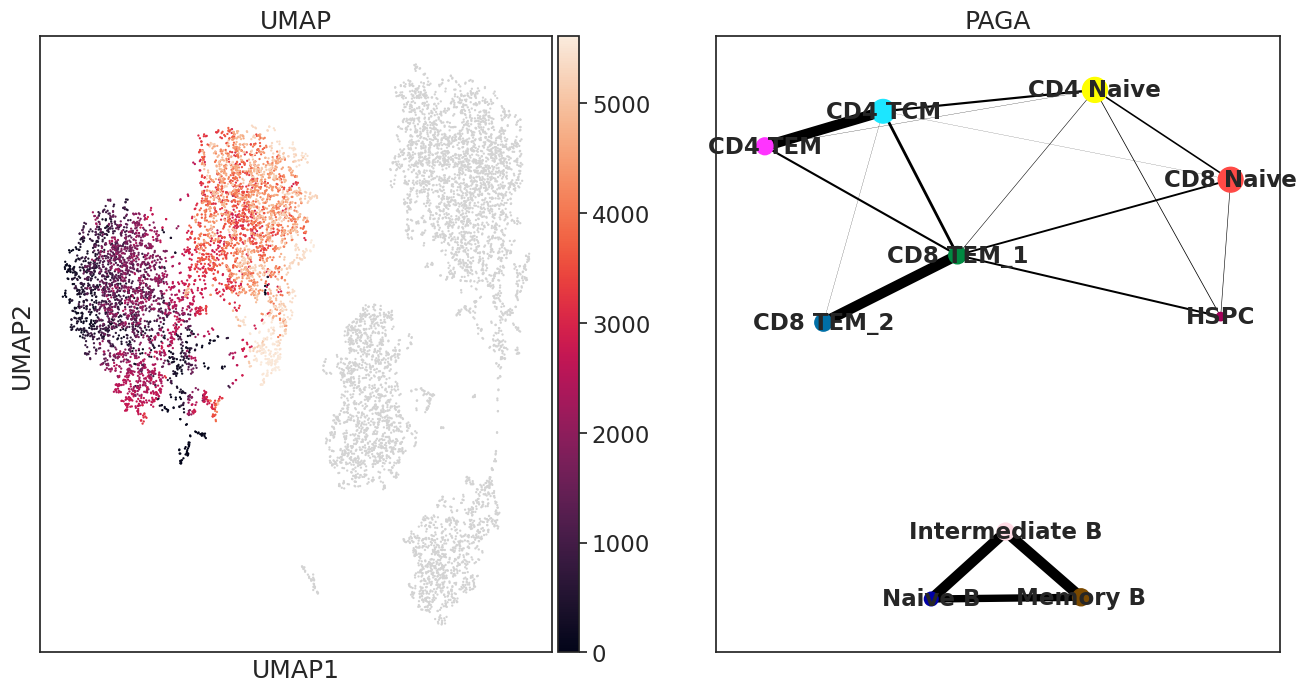

In [145]:
# Compare UMAP and PAGA layouts
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
adata_pre_sub, adata_post_sub=trajectory_plot(multiome_rna,scMDC_emb,"cell_type","embed")
sc.tl.umap(adata_post_sub,random_state=0)
sc.pl.umap(
    adata_post_sub, color="dpt_after", ax=axs[0], show=False, title="UMAP", legend_loc="on data"
)
sc.tl.paga(adata_post_sub, groups="cell_type")
sc.pl.paga(adata_post_sub, ax=axs[1], title="PAGA")

In [146]:
temp_dpt_after=adata_post_sub.obs.groupby(['cell_type'],observed=True)['dpt_after'].mean()
pd.DataFrame(temp_dpt_after)

dpt_after
cell_type                  
CD4 TCM         4805.770833
CD4 Naive       4094.575486
CD8 Naive       1473.154046
CD4 TEM         4324.000000
Naive B                 NaN
CD8 TEM_1        860.534091
Memory B                NaN
CD8 TEM_2               NaN
Intermediate B          NaN
HSPC                    NaN

In [147]:
# # Define PAGA positions based on the UMAP layout -
# # for each cluster we use the mean of the UMAP positions from the cells in that cluster
# pos = pd.DataFrame(adata_pre_sub.obsm["X_umap"], index=adata_pre_sub.obs_names)
# pos["group"] = adata_pre_sub.obs[adata_pre_sub.uns["paga"]["groups"]]
# pos = pos.groupby("group", observed=True).mean()

# # Plot UMAP in the background
# ax = sc.pl.umap(adata_pre_sub, color='dpt_pseudotime', show=False)
# # Plot PAGA ontop of the UMAP
# sc.pl.paga(
#     adata_pre_sub,
#     color="cell_type",
#     threshold=0.2,
#     node_size_scale=5,
#     edge_width_scale=1,
#     pos=pos.values,
#     random_state=0,
#     ax=ax,
# )

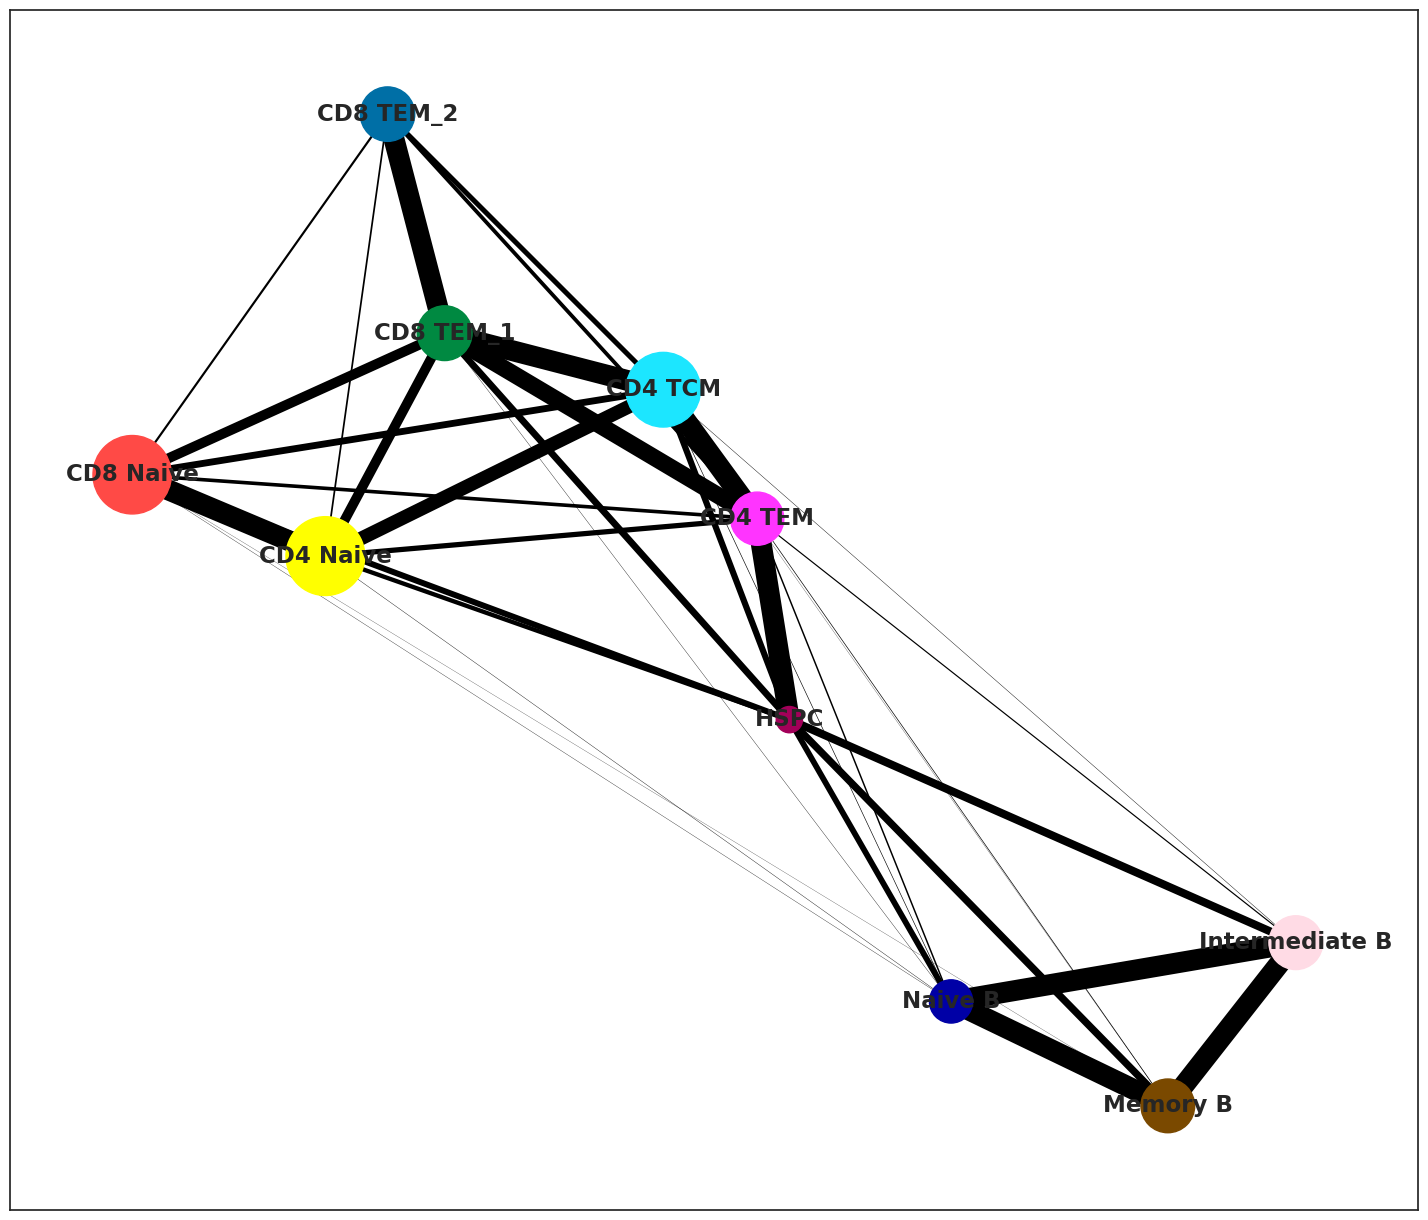

In [148]:
sc.tl.paga(adata_pre_sub, groups='cell_type')
sc.pl.paga(adata_pre_sub, node_size_scale=10, edge_width_scale=2,cmap='Set3')

In [149]:
# sc.tl.draw_graph(adata_pre_sub,init_pos='paga')
# sc.tl.draw_graph(adata_pre_sub)

In [150]:
j=0
umap=[]
sc.tl.umap(adata_pre_sub)
umap.append(adata_pre_sub)
for idx,i in enumerate(all_dpt):
    
    sc.tl.umap(i)
    umap.append(i)


   #  if idx%4==0:
   #     j=j+1
   #  sc.pl.umap(i, color='dpt_after', title='UMAP', show=False, frameon=False, ax=axes[j,idx%4])
    

In [151]:
# fig, ax = plt.subplots(figsize=(5, 5))
# for idx,i in enumerate(umap):    
#     if idx==0:
#         color_text='dpt_pseudotime'
#     else:
#         color_text='dpt_after'
#     # Define PAGA positions based on the UMAP layout -
#     # for each cluster we use the mean of the UMAP positions from the cells in that cluster
#     pos = pd.DataFrame(i.obsm["X_umap"], index=i.obs_names)
#     pos["group"] = i.obs[i.uns["paga"]["groups"]]
#     pos = pos.groupby("group", observed=True).mean()

#     # Plot UMAP in the background
#     ax = sc.pl.umap(i, color=color_text, show=False, cmap="coolwarm")
#     # Plot PAGA ontop of the UMAP
#     sc.pl.paga(
#         i,
#         color="cell_type",
#         threshold=0.2,
#         node_size_scale=5,
#         edge_width_scale=1,
#         pos=pos.values,
#         random_state=0,
#         ax=ax,
#     )

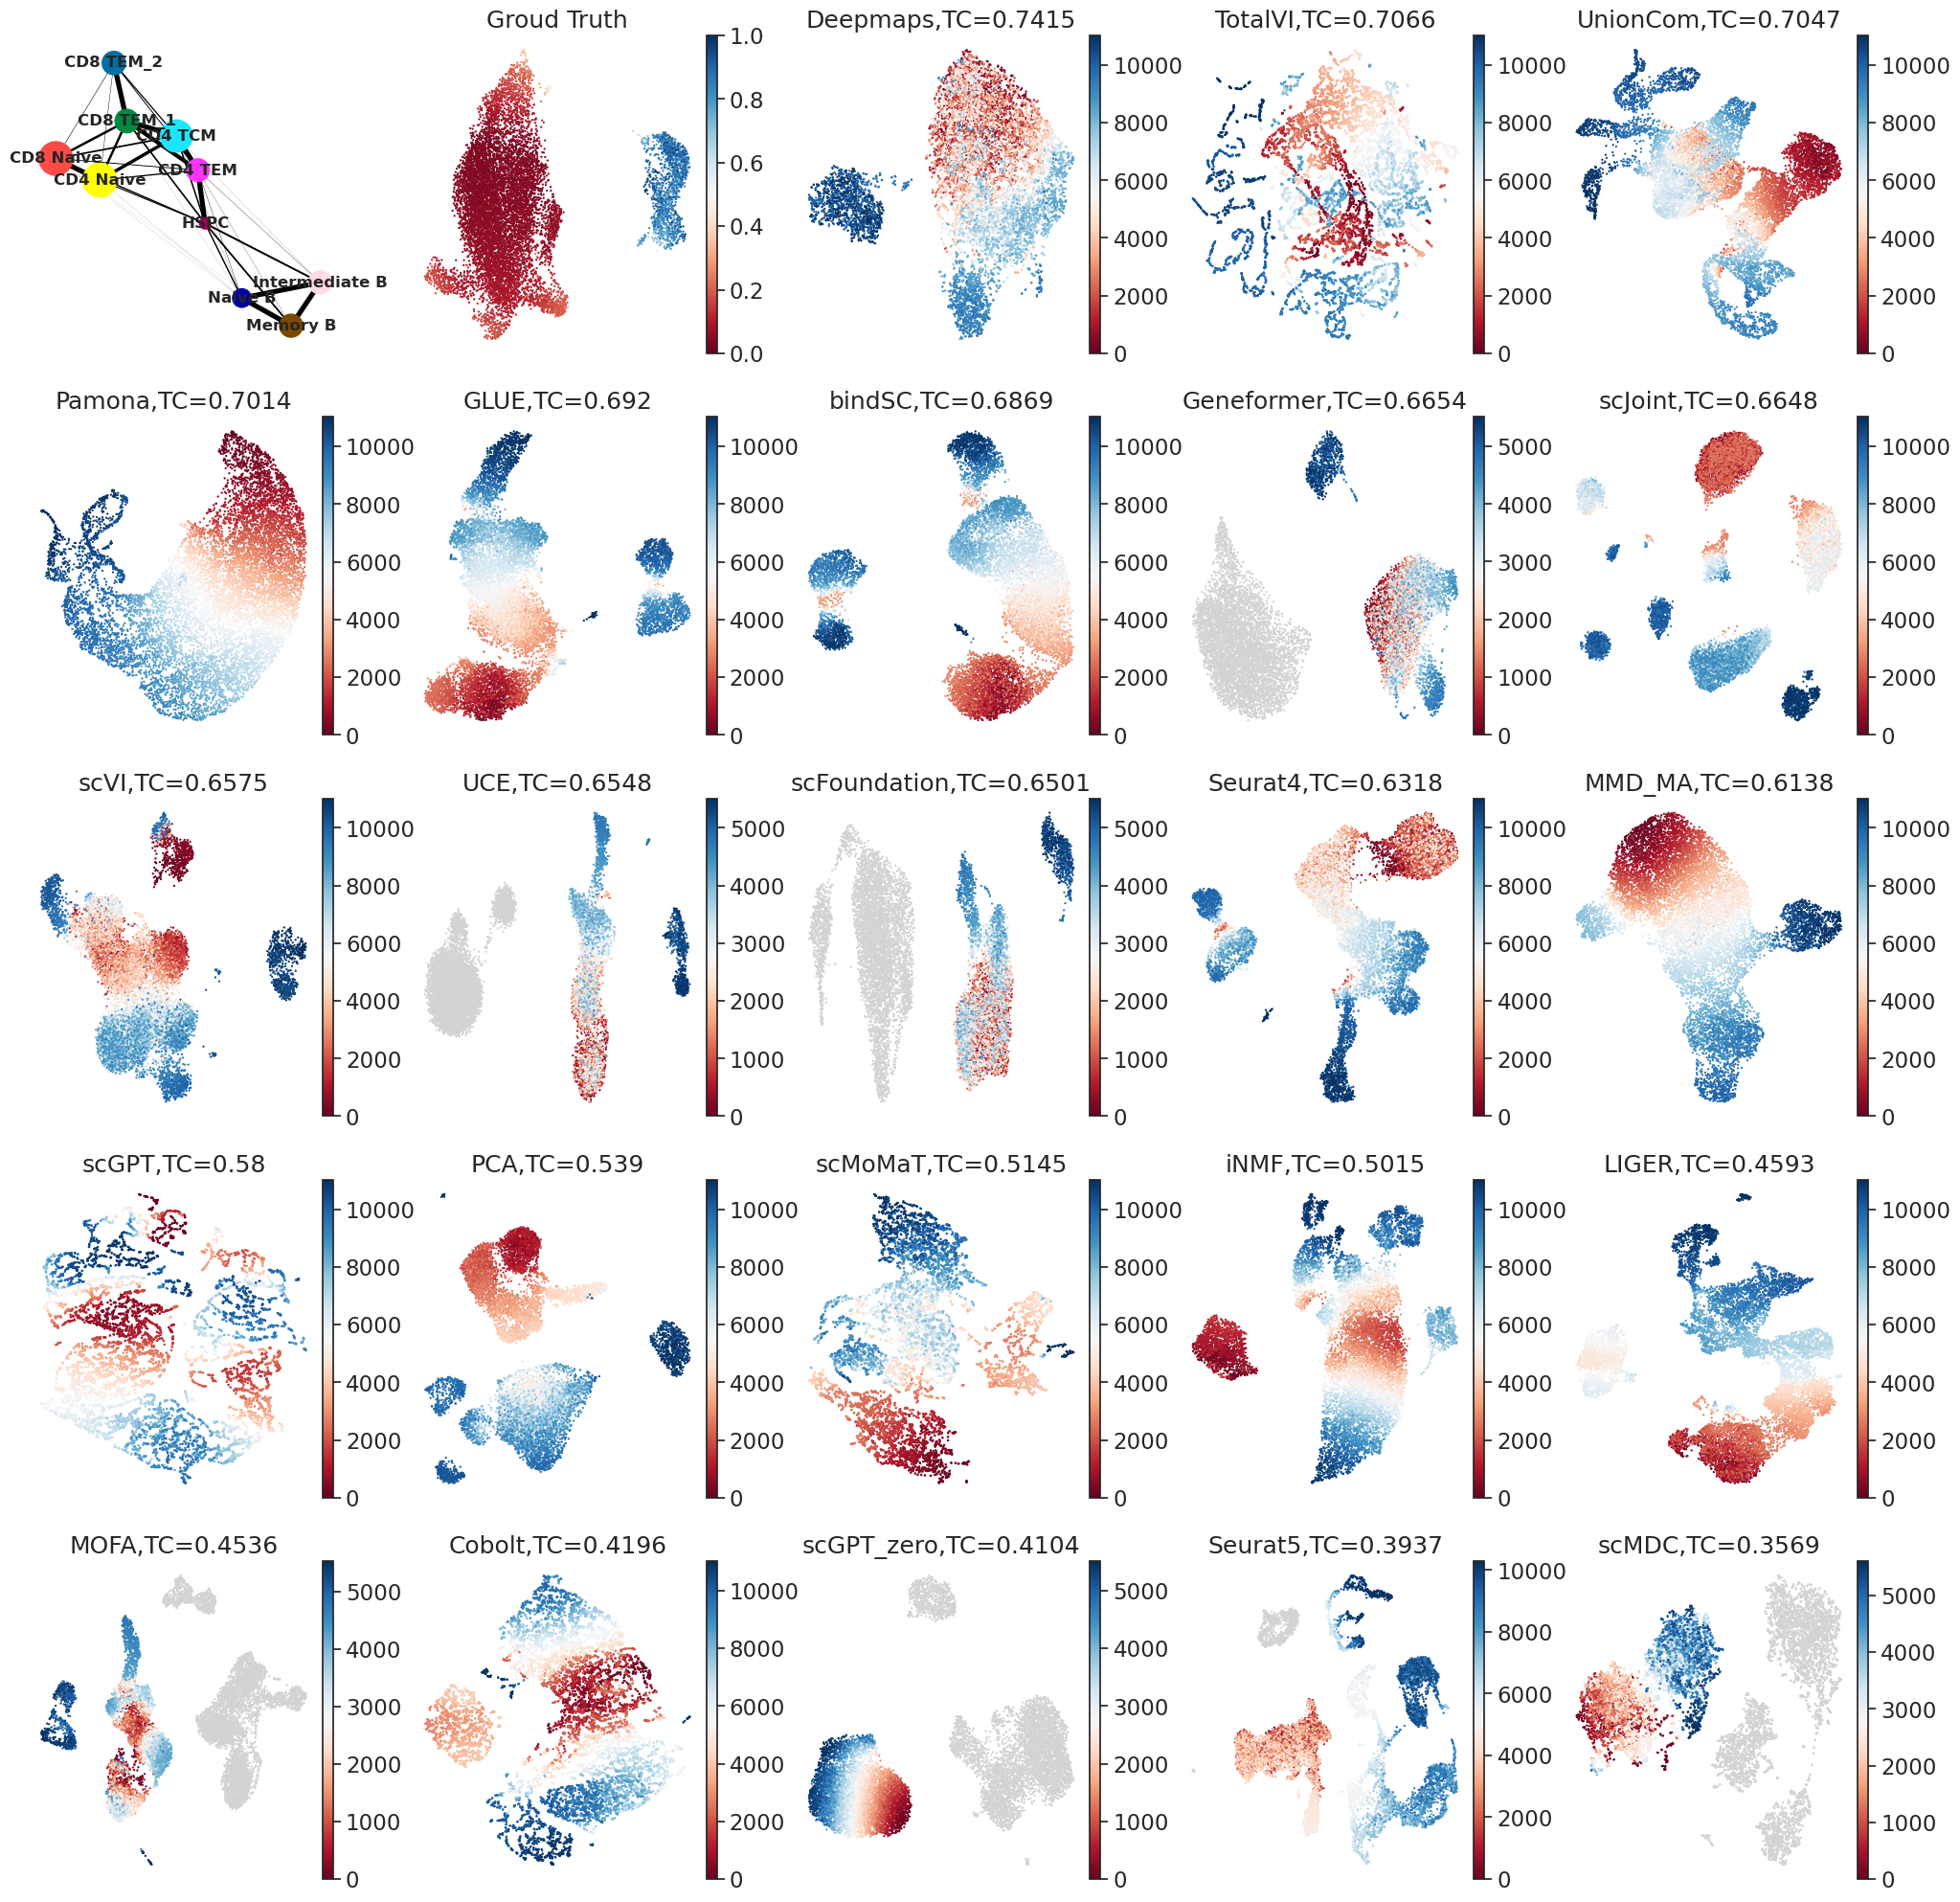

In [158]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(25, 25))
for ax in axes.flatten():
    ax.axis('off')
j=0
sc.tl.paga(umap[0], groups='cell_type')
sc.pl.paga(umap[0],node_size_scale=2,edge_width_scale=0.5,ax=axes[0,0],show=False,fontsize=12)
for idx,i in enumerate(umap):    
    if (idx+1)%5==0:
        j=j+1
    if idx==0:
        sc.pl.umap(i, color='dpt_pseudotime',title='Groud Truth',show=False, frameon=False, ax=axes[j,(idx+1)%5], cmap="RdBu")
        
    else:
        # break
        sc.pl.umap(i, color='dpt_after',title=titles[idx-1]+',TC='+str(scores[idx-1]),show=False, frameon=False, ax=axes[j,(idx+1)%5], cmap="RdBu")
        # sc.tl.paga(i, groups='cell_type')
        # sc.pl.paga(i, node_size_scale=10, edge_width_scale=2)

        # axes[j-1, idx % 5].annotate('Annotation', (1, 1), textcoords="offset points", xytext=(0,10), ha='center')
fig.savefig('/mnt/nas/user/yixuan/Multiomics-benchmark-main/evaluation/workflow/scripts/graphs/10x_umap.png',dpi=400)
    

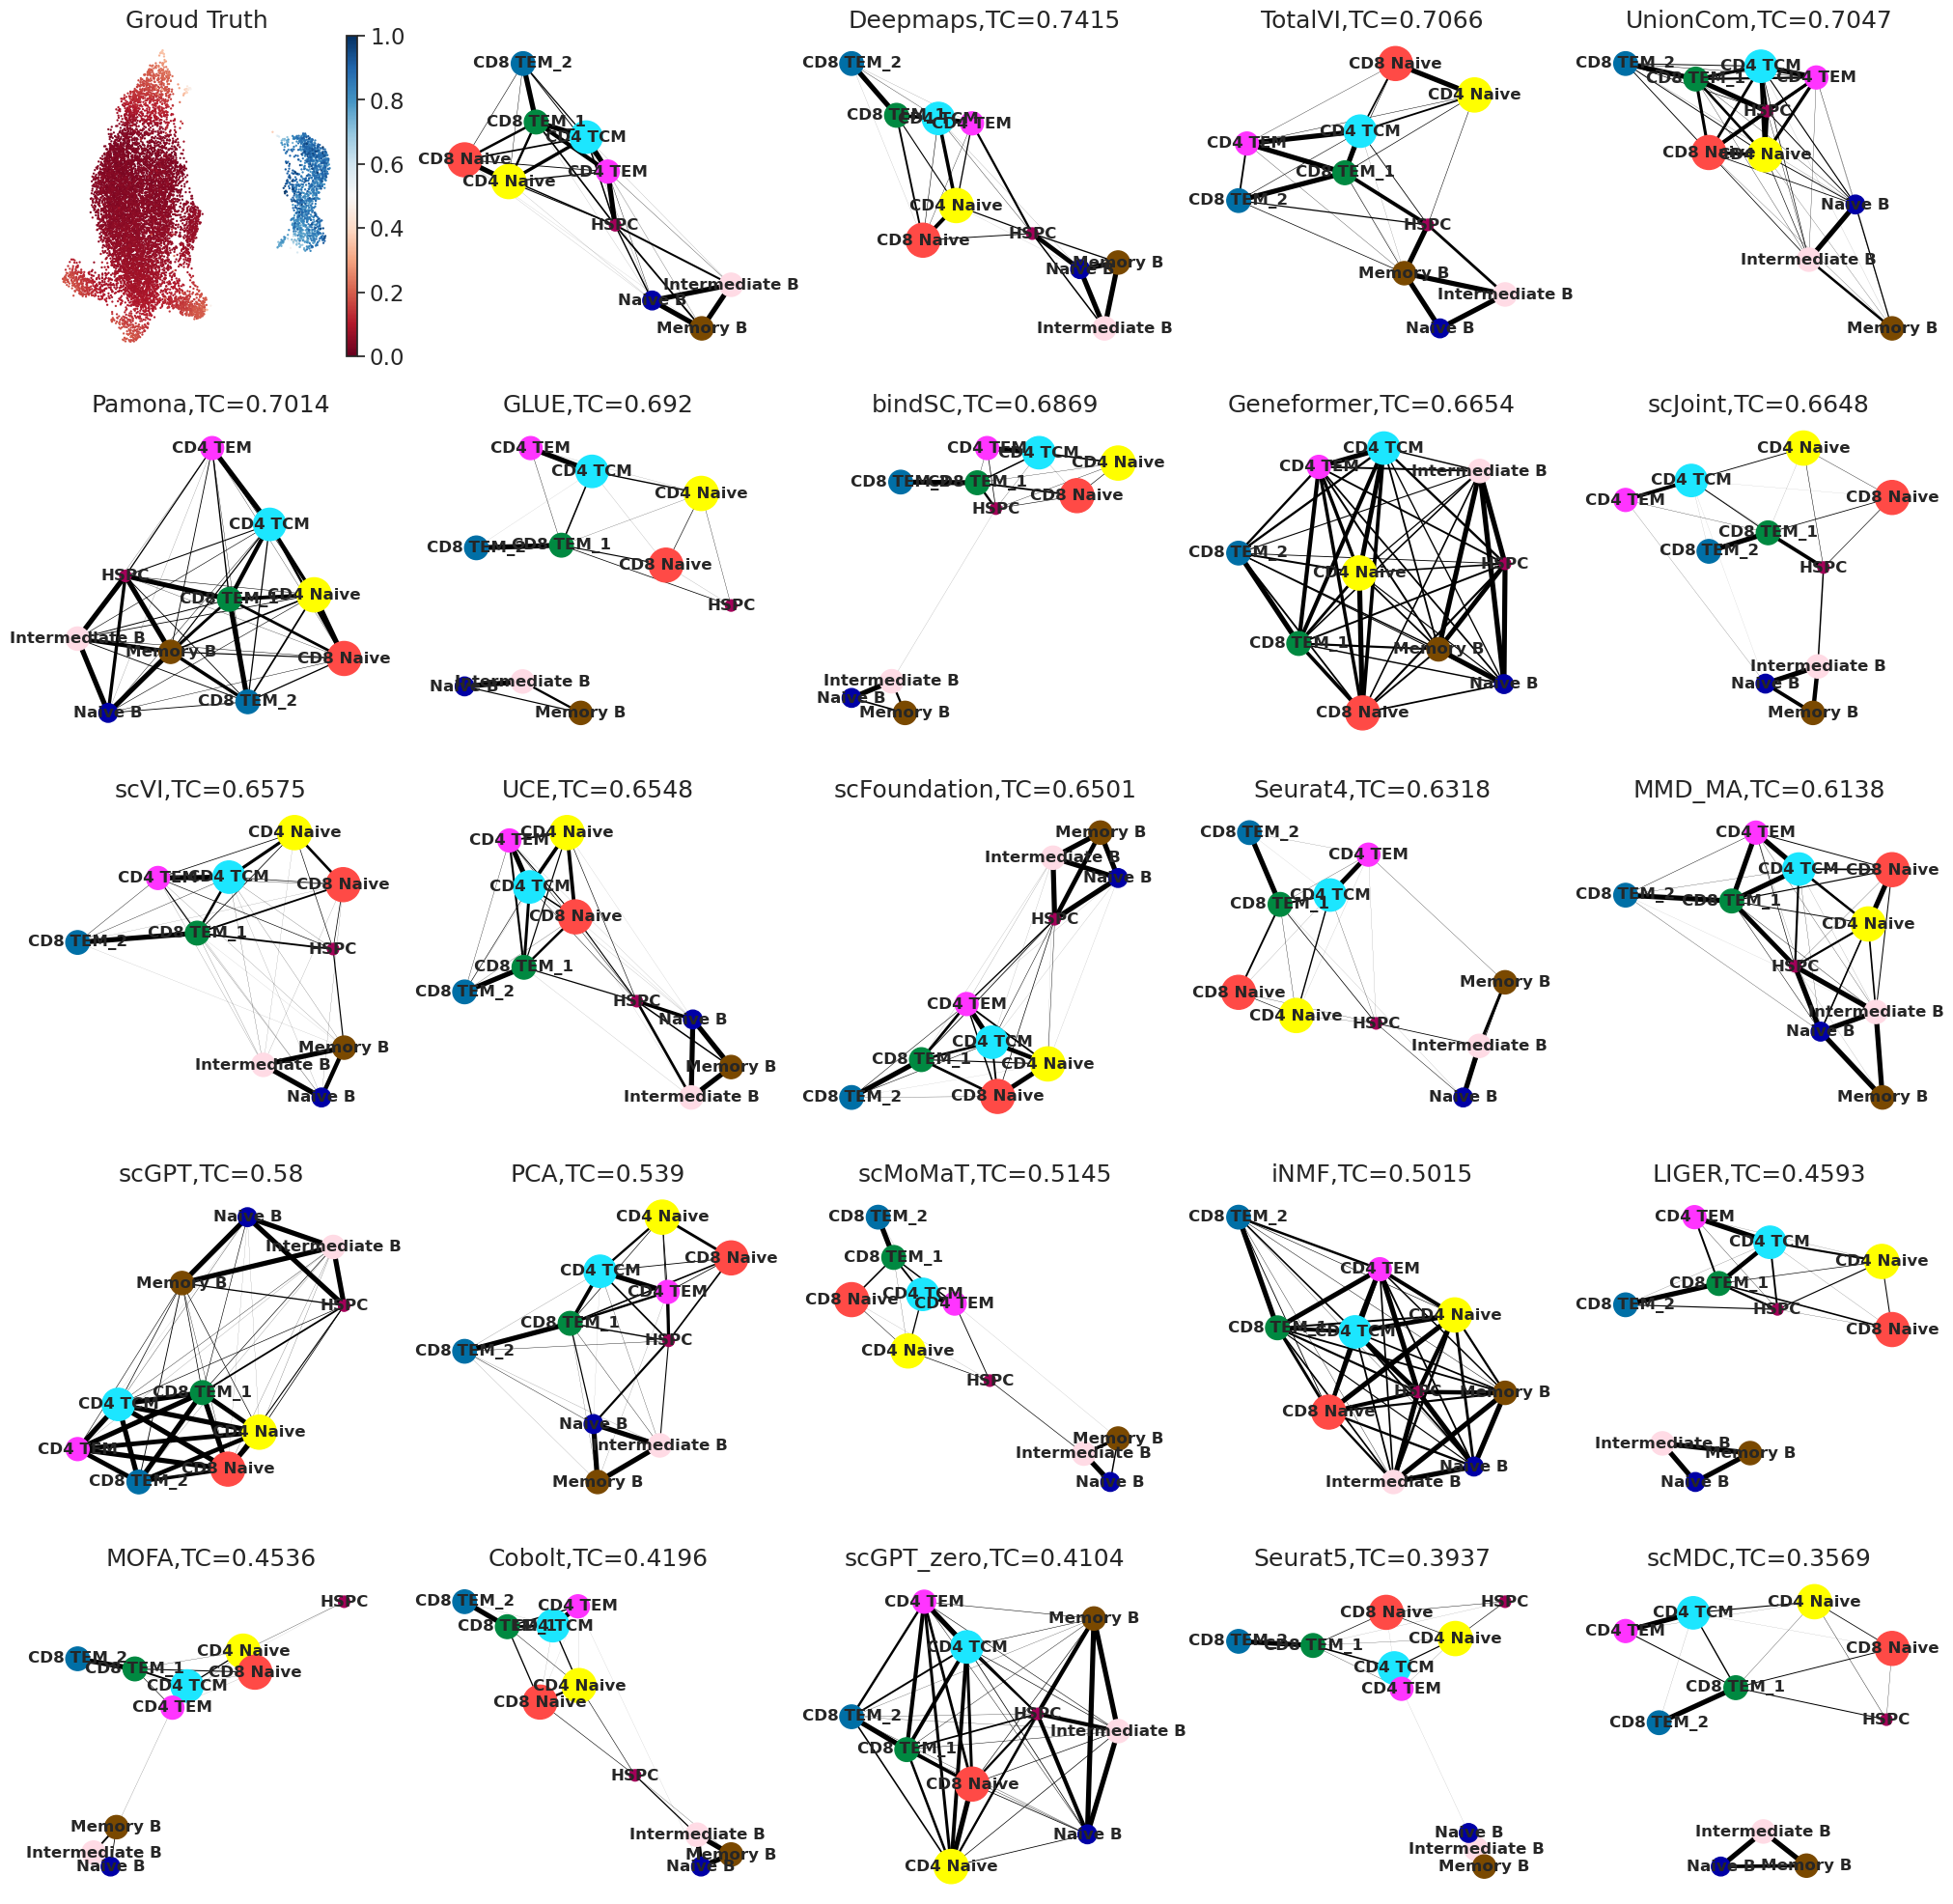

In [155]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(25, 25))
for ax in axes.flatten():
    ax.axis('off')
j=0
sc.pl.umap(umap[0], color='dpt_pseudotime',title='Groud Truth',show=False, frameon=False, ax=axes[0,0], cmap="RdBu")

for idx,i in enumerate(umap):    
    if (idx+1)%5==0:
        j=j+1
    if idx==0:
        sc.tl.paga(i, groups='cell_type')
        sc.pl.paga(i,node_size_scale=2,edge_width_scale=0.5, ax=axes[j,(idx+1)%5],show=False,fontsize=12)        
    else:
        # break
        # sc.pl.umap(i, color='dpt_after',title=titles[idx-1]+',TC='+str(scores[idx-1]),show=False, frameon=False, ax=axes[j,(idx+1)%5])
        sc.tl.paga(i, groups='cell_type')
        sc.pl.paga(i,node_size_scale=2,edge_width_scale=0.5, ax=axes[j,(idx+1)%5],show=False,fontsize=12,title=titles[idx-1]+',TC='+str(scores[idx-1]))  
        # sc.tl.paga(i, groups='cell_type')
        # sc.pl.paga(i, node_size_scale=10, edge_width_scale=2)

        # axes[j-1, idx % 5].annotate('Annotation', (1, 1), textcoords="offset points", xytext=(0,10), ha='center')

fig.savefig('/mnt/nas/user/yixuan/Multiomics-benchmark-main/evaluation/workflow/scripts/graphs/10x_connect.png',dpi=400)

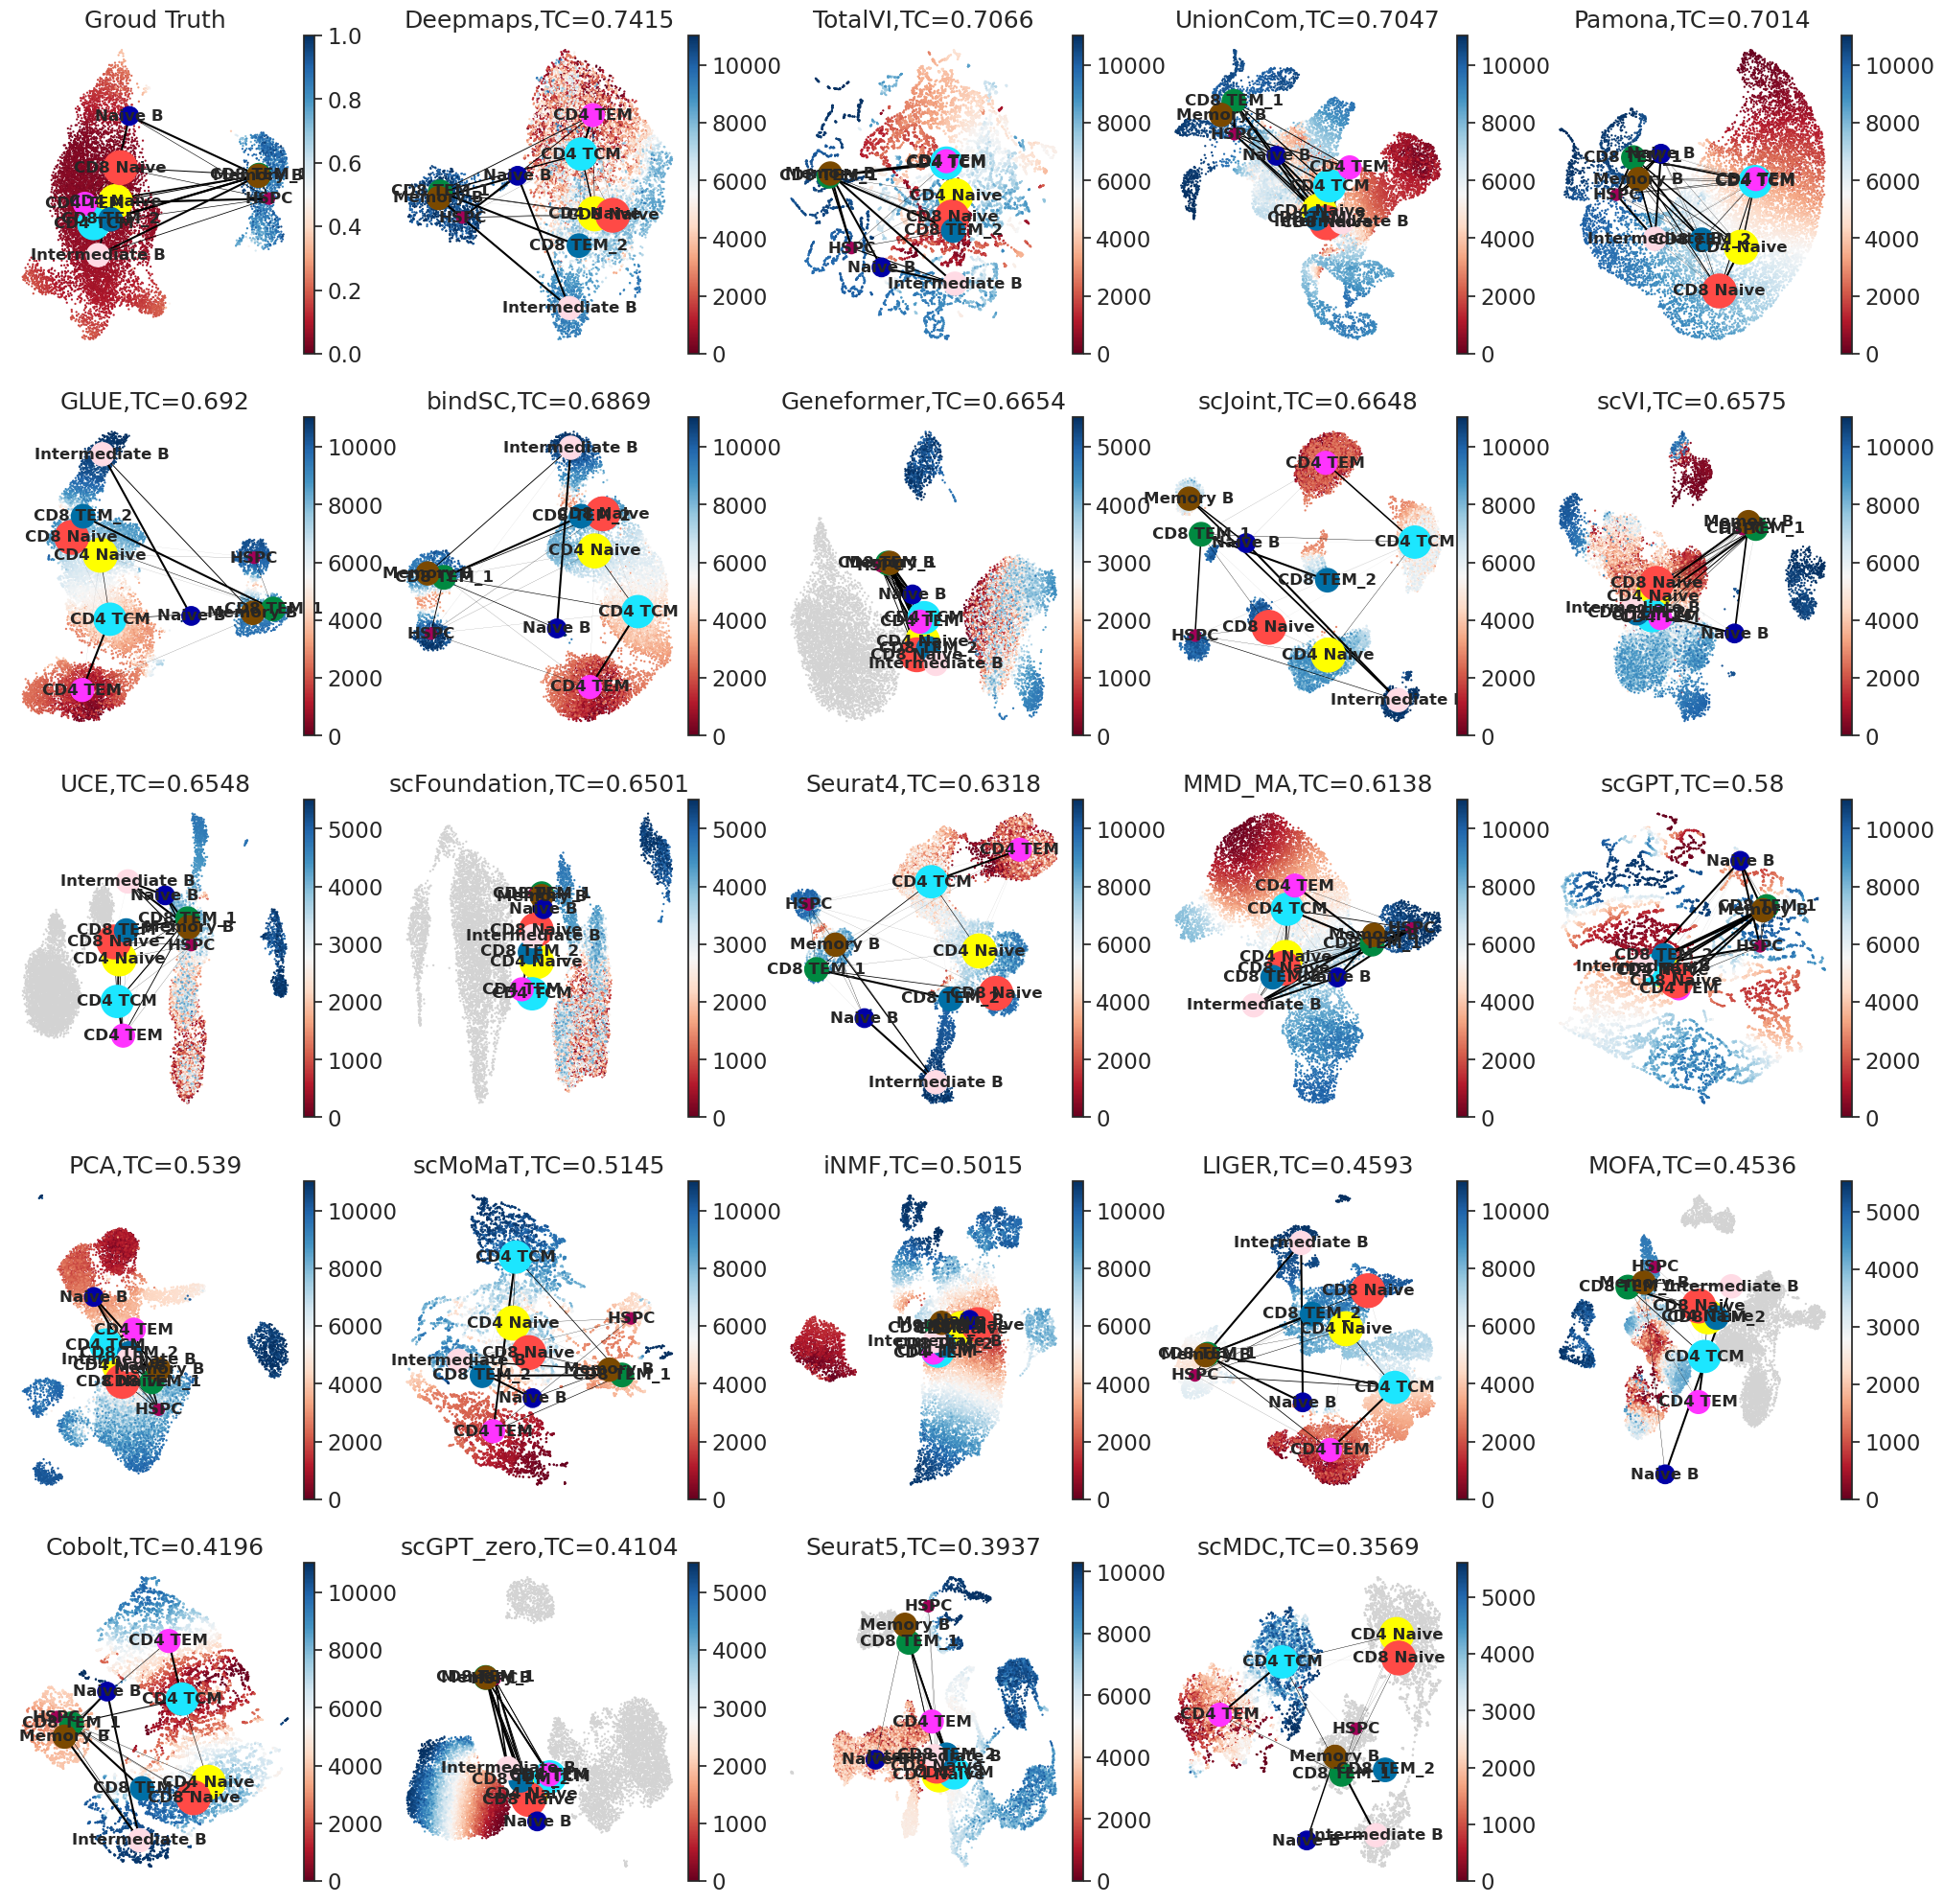

In [159]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(25, 25))
for ax in axes.flatten():
    ax.axis('off')
j=0
# sc.tl.paga(umap[0], groups='cell_type')
# sc.pl.paga(umap[0],node_size_scale=2,edge_width_scale=0.5,ax=axes[0,0],show=False,fontsize=12)
for idx,i in enumerate(umap):    
    if idx%5==0:
        j=j+1
    if idx==0:
        pos = pd.DataFrame(i.obsm["X_umap"], index=i.obs_names)
        pos["group"] = i.obs[i.uns["paga"]["groups"]]
        pos = pos.groupby("group", observed=True).mean()

        # Plot UMAP in the background
        sc.pl.umap(i, color='dpt_pseudotime',title='Groud Truth',show=False, frameon=False, ax=axes[j-1,idx%5], cmap="RdBu")
        # Plot PAGA ontop of the UMAP
        sc.pl.paga(
            i,
            color="cell_type",
            # threshold=0.2,
            node_size_scale=2,
            edge_width_scale=0.2,
            pos=pos.values,
            random_state=0,
            ax=axes[j-1,idx%5],
            show=False,
            fontsize=12,
            cmap='Set3',
        )
        
    else:
        # break
        # sc.pl.umap(i, color='dpt_after',title=titles[idx-1]+',TC='+str(scores[idx-1]),show=False, frameon=False, ax=axes[j,idx%5])
        pos = pd.DataFrame(i.obsm["X_umap"], index=i.obs_names)
        pos["group"] = i.obs[i.uns["paga"]["groups"]]
        pos = pos.groupby("group", observed=True).mean()

        # Plot UMAP in the background
        sc.pl.umap(i, color='dpt_after',title=titles[idx-1]+',TC='+str(scores[idx-1]),show=False, frameon=False, ax=axes[j-1,idx%5], cmap="RdBu", legend_loc='none')
        # Plot PAGA ontop of the UMAP
        sc.pl.paga(
            i,
            color="cell_type",
            # threshold=0.2,
            node_size_scale=2,
            edge_width_scale=0.2,
            pos=pos.values,
            random_state=0,
            ax=axes[j-1,idx%5],
            show=False,
            fontsize=12,
            cmap='Set3',
        )
        # sc.tl.paga(i, groups='cell_type')
        # sc.pl.paga(i, node_size_scale=10, edge_width_scale=2)

        # axes[j-1, idx % 5].annotate('Annotation', (1, 1), textcoords="offset points", xytext=(0,10), ha='center')
fig.savefig('/mnt/nas/user/yixuan/Multiomics-benchmark-main/evaluation/workflow/scripts/graphs/10x_comb.png',dpi=400)
    

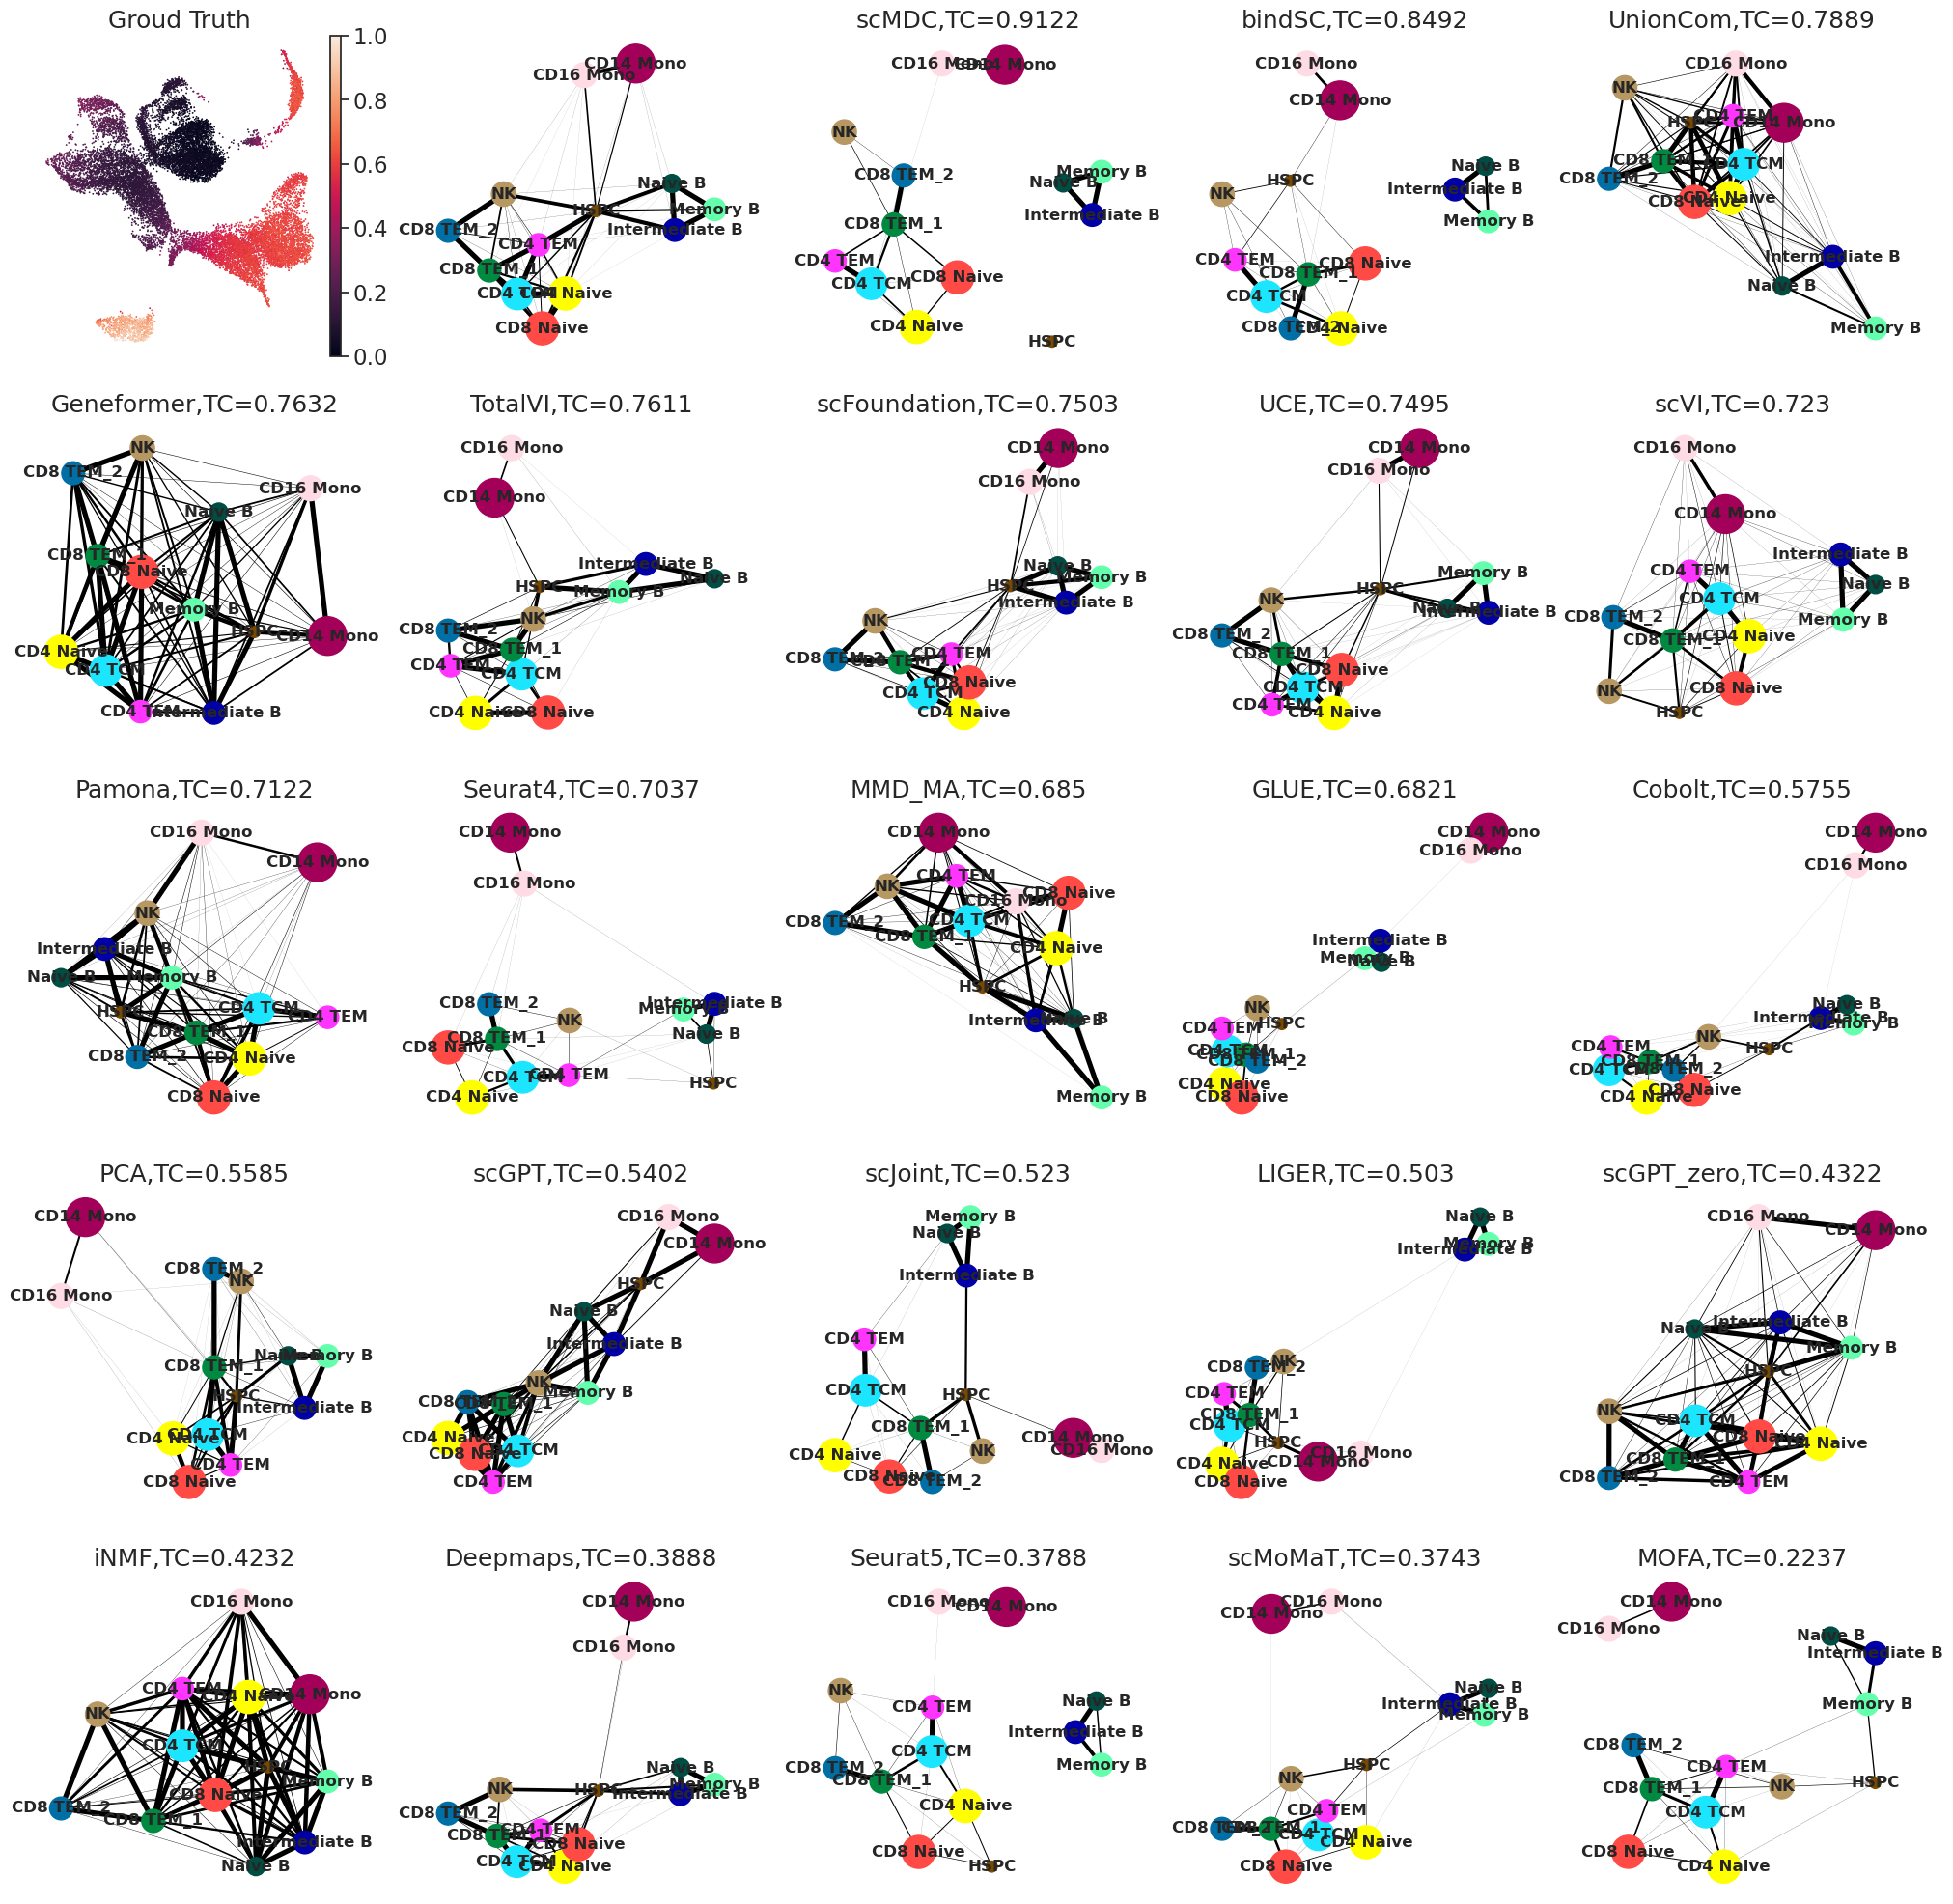

In [ ]:
fig

In [90]:
# fig.savefig('/mnt/nas/user/yixuan/Multiomics-benchmark-main/evaluation/workflow/scripts/graphs/10x_bc.png',dpi=400)